Best parameters: {'C': 1, 'class_weight': {0: np.float64(0.5782918149466192), 1: np.float64(3.6931818181818183)}}
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.98      0.99      0.98      1453
        Spam       0.94      0.84      0.89       219

    accuracy                           0.97      1672
   macro avg       0.96      0.92      0.94      1672
weighted avg       0.97      0.97      0.97      1672



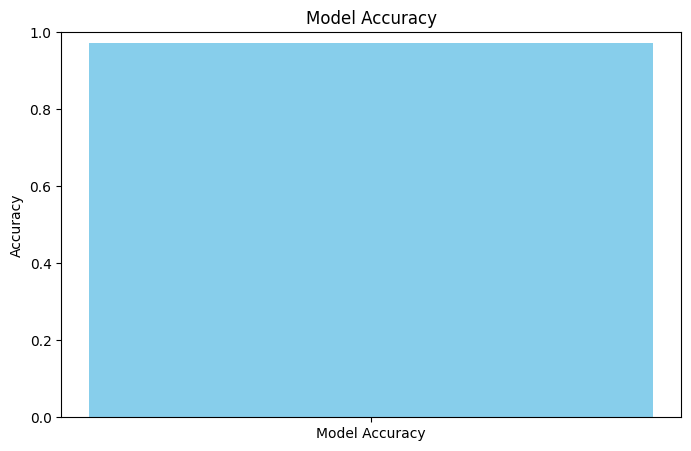

Message:  Congratulations! You've won a $1000 Walmart gift card.
Classification:  Spam


In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import re
import joblib
import numpy as np  # Make sure numpy is imported

# Load the dataset
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]  # Keep only the relevant columns
data.columns = ['label', 'message']  # Rename columns for clarity
data['label'] = data['label'].map({'ham': 0, 'spam': 1})  # Encode labels

# Preprocess the text
def preprocess_text(text):
    # Remove non-alphabetic characters and lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

data['message'] = data['message'].apply(preprocess_text)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data['message'], data['label'], test_size=0.3, random_state=42
)

# Vectorize the text data using TF-IDF with bigrams and more features
tfidf = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Grid search for hyperparameter tuning
param_grid = {
    'C': [1],
    
    'class_weight': [class_weight_dict]
}

grid_search = GridSearchCV(SVC(class_weight=class_weight_dict), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)

# Train the model with the best parameters from Grid Search
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Legitimate', 'Spam'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# Save the model and vectorizer for later use
joblib.dump(best_model, 'spam_classifier_svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Plot the accuracy
accuracies = [accuracy]  # Example: Storing the current accuracy
plt.figure(figsize=(8, 5))
plt.bar(['Model Accuracy'], accuracies, color='skyblue')
plt.ylim(0, 1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.show()

# Usage Example
def classify_sms(message):
    # Preprocess and vectorize the input message
    message = preprocess_text(message)
    vectorized_message = tfidf.transform([message])
    prediction = best_model.predict(vectorized_message)
    return 'Spam' if prediction[0] == 1 else 'Legitimate'

# Test the function
example_message = "Congratulations! You've won a $1000 Walmart gift card."
print("Message: ", example_message)
print("Classification: ", classify_sms(example_message))
